In [1]:
#import panda packages
import pandas as pd

#Read Data from CSV file And Store It IN DATAFRAME
df = pd.read_csv('NSE-TATAGLOBAL.csv')

#print TOP 10 RECORD
df.head(10)

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
0,2019-01-04,210.60,214.90,210.00,213.50,213.80,1213181.0,2583.05
1,2019-01-03,214.95,215.35,209.90,210.55,210.05,2096553.0,4433.50
2,2019-01-02,219.00,220.35,213.60,214.20,214.60,1081778.0,2340.31
3,2019-01-01,219.95,221.05,218.05,218.95,219.10,716275.0,1571.63
4,2018-12-31,222.00,223.65,218.85,219.55,219.40,965858.0,2131.09
5,2018-12-28,221.75,223.30,219.55,220.75,220.80,2263147.0,5006.86
6,2018-12-27,221.80,224.90,215.20,220.10,220.05,9509683.0,20912.50
7,2018-12-26,220.40,220.40,212.40,217.95,218.55,1598566.0,3456.42
8,2018-12-24,215.55,224.00,215.40,219.05,219.05,5808490.0,12802.57
9,2018-12-21,211.00,219.60,210.80,215.00,215.40,5654362.0,12257.27


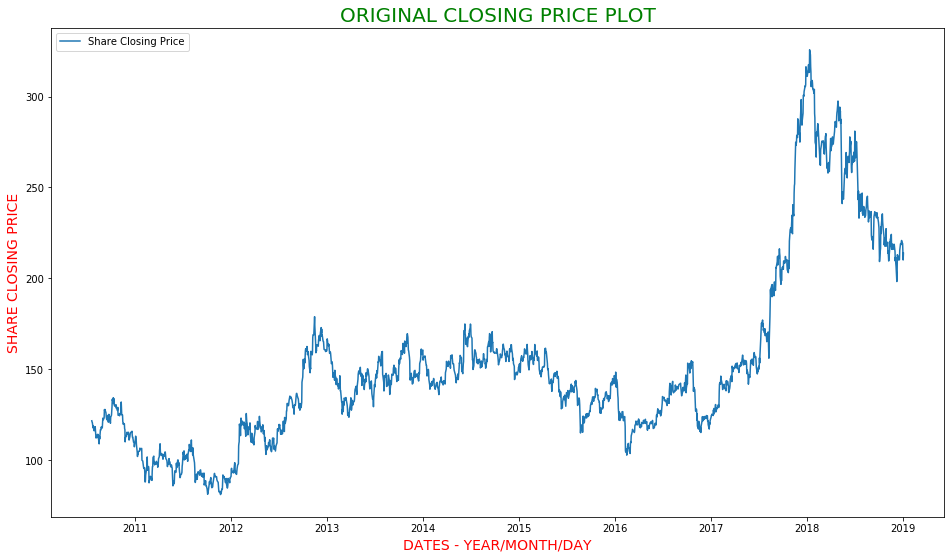

In [2]:
#setting index as date
df['Date'] = pd.to_datetime(df.Date,format='%Y-%m-%d')
df.index = df['Date']

#to plot the graph
import matplotlib.pyplot as plt
%matplotlib inline

# Plot everything by leveraging the very powerful matplotlib package
fig, ax = plt.subplots(figsize=(16,9))

ax.plot(df['Close'], label='Share Closing Price')

ax.set_xlabel('DATES - YEAR/MONTH/DAY',fontsize=14, color='r')
ax.set_ylabel('SHARE CLOSING PRICE',fontsize=14, color='r')
ax.set_title('ORIGINAL CLOSING PRICE PLOT', fontsize=20, color='g')
ax.legend()

In [6]:
#Sorting
data = df.sort_index(ascending=True, axis = 0)

#Create a Seperate Dataset
new_data = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'Close'])

for i in range(0,len(data)):
     new_data['Date'][i] = data['Date'][i]
     new_data['Close'][i] = data['Close'][i]

new_data.to_csv('01_LSTM1.LSTMData.csv')
new_data.head(10)

,Date,Close
0,2010-07-21 00:00:00,121.55
1,2010-07-22 00:00:00,120.9
2,2010-07-23 00:00:00,120.65
3,2010-07-26 00:00:00,117.6
4,2010-07-27 00:00:00,118.65
5,2010-07-28 00:00:00,118.25
6,2010-07-29 00:00:00,116.6
7,2010-07-30 00:00:00,116.05
8,2010-08-02 00:00:00,117.3
9,2010-08-03 00:00:00,118.3


In [7]:
# SETTING new_data INDEX
new_data.index = new_data.Date
new_data.drop('Date',axis =1, inplace = True)

# TAKE ALL CLOSING PRICE
dataset = new_data.values
#print(dataset)

#creating train and test sets 
# 3 Months Prediction
train = dataset[:2055] 
test = dataset[2055:] 

train_df = pd.DataFrame(train)
test_df = pd.DataFrame(test)

train_df.to_csv('01_LSTM2.LSTM_TrainData.csv')
test_df.to_csv('01_LSTM3.LSTM_TestData.csv')

#print(train)
#new_data.head()

In [8]:
new_data.shape, train_df.shape, test_df.shape

((2100, 1), (2055, 1), (45, 1))

In [9]:
#importing required libraries 
import numpy as np
from sklearn.preprocessing import MinMaxScaler 

#converting dataset into x_train and y_train
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

x_train, y_train = [], []
for i in range(60,len(train)):
    x_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])

x_train, y_train = np.array(x_train), np.array(y_train)

x_train_df_beforereshape = pd.DataFrame(x_train)
x_train_df_beforereshape.to_csv('01_LSTM4.LSTM_X_TrainData_BeforeReshape.csv')

x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

y_train_df = pd.DataFrame(y_train)
y_train_df.to_csv('01_LSTM5.LSTM_Y_TrainData.csv')

In [10]:
#importing required libraries 
from keras.models import Sequential 
from keras.layers import Dense, Dropout, LSTM

# create and fit the LSTM network
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2)

Using TensorFlow backend.


Epoch 1/1
 - 131s - loss: 0.0017


In [11]:
#predicting 63 values, using past 60 from the train data
inputs = new_data[len(new_data) - len(test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])

X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
closing_price_pred = model.predict(X_test)
closing_price_pred = scaler.inverse_transform(closing_price_pred)

#print(closing_price_pred)
#closing_price_pred_df = pd.DataFrame(closing_price_pred)
#closing_price_pred_df.to_csv('01_LSTM6.LSTM_Predict_ClosePrice.csv')

In [12]:
date_list = []
original_close_list = []
stcokclose_preds =[]

stcokclose_preds = [item for sublist in closing_price_pred for item in sublist]

# TAKE DATE FROM TEST DATA FRAME AND CONVERT IT TO LIST
date_list = list(new_data.index.values) 
date_list_train = date_list[:2055] 
date_list_test = date_list[2055:]
#print (date_list)

original_close_list = list(new_data['Close'])
original_close_list_train = original_close_list[:2055]
original_close_list_test = original_close_list[2055:]

# CREATE DICTIONARY USING LIST
dict = {'Date':date_list_test,'Original_Close': original_close_list_test,'Predict_Close': stcokclose_preds} 
#print(dict)

predict_df = pd.DataFrame(dict)  #CONVERT DICTIONARY TO DATAFRAME
predict_df.to_csv('01_LSTM6.LSTM_Predict_ClosePrice.csv')
predict_df.head(10)

,Date,Original_Close,Predict_Close
0,2018-10-31,217.85,220.800766
1,2018-11-01,217.75,220.436218
2,2018-11-02,217.65,219.752258
3,2018-11-05,219.85,219.032166
4,2018-11-06,213.80,218.811859
5,2018-11-07,215.20,217.742966
6,2018-11-09,209.50,216.816193
7,2018-11-12,214.70,215.080444
8,2018-11-13,219.95,214.278000
9,2018-11-14,217.40,214.878159


In [13]:
#calculate rmse
#MSE (Mean Squared Error) = np.mean((y_test - y_predtest)**2)
#RMSE (Root Mean Squared Error) = np.sqrt(MSE)

x = np.power(((predict_df['Original_Close'])-predict_df['Predict_Close']),2)
mse = np.mean(x)
rmse = np.sqrt(mse)
rmse

4.656802175030497

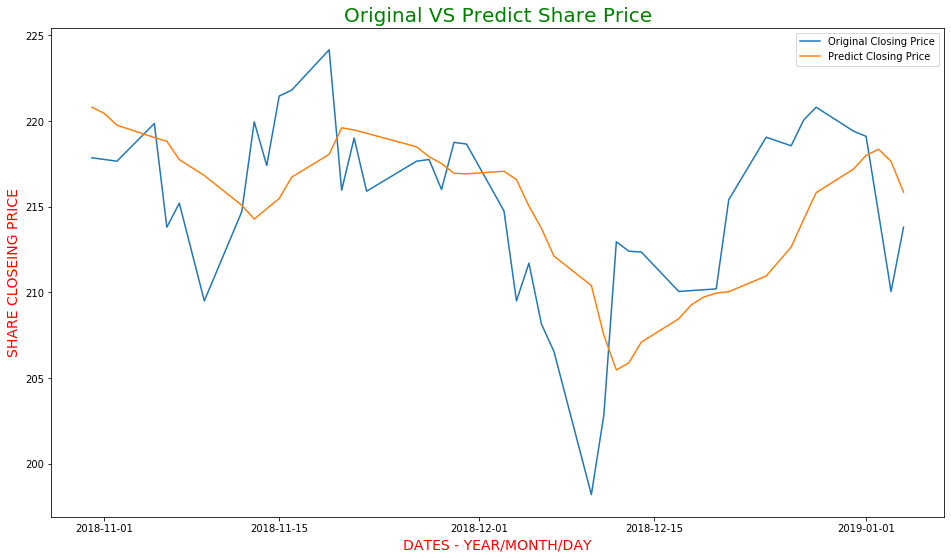

In [15]:
# Plot everything by leveraging the very powerful matplotlib package
fig, ax = plt.subplots(figsize=(16,9))

ax.plot(predict_df['Date'],predict_df['Original_Close'],label = 'Original Closing Price')
ax.plot(predict_df['Date'],predict_df['Predict_Close'],label = 'Predict Closing Price')

ax.set_xlabel('DATES - YEAR/MONTH/DAY',fontsize=14, color='r')
ax.set_ylabel('SHARE CLOSEING PRICE',fontsize=14, color='r')
ax.set_title('Original VS Predict Share Price', fontsize=20, color='g')
ax.legend()